# Introduction: Bayesian Inference

The purpose of this project/notebook is to create a few simple implementations of inference methods from Bayesian statistics. Both for demonstration and self-learning. Currently, the project has finished two of the 3 goals that I hope to include. 

First, is an implementation of Bayesian point estimation for a sample from a Bernoulli distribution. This is interpreted as creating a sample of outcomes from flipping a potentially biased coin. Then "training" a "Bayesian Learner" on this data, i.e., finding the posterior distribution on the model parameter given the sampled data. This is then used to produce a point estimate of the proportion of the Bernoulli random variable (i.e., the weighting of the coin) via a maximum a posteriori estimation (MAP), thus mixing Bayesian and frequentist methods.

Second, is an implementation of the Naive Bayes Classifier. While the implementation of the classifier is relatively general, it is applied to the problem of classifying points in $\mathbb{R}^2$ as inside or outside of a given collection of circles, where inclusion inside each circle corresponds to its own class. This is tested on a collection of sample data.

The last goal is to extend the Naive Bayes Classifier to allow the parameters found during the learning process (means and standard deviations of points in each class) to have their own prior distribution, creating an implementation of a Hierarchical Naive Bayes Classifier. Currently this has not been included and planned for a later date.

## Point Estimation for Tosses Weighted of a Coin

The following code implements a coin toss experiment class, where the weighting of the coin $p$ can be pre-set, and a simple "Bayesian learner" that learns the weighting of the coin given data, assuming a given prior and sample distribution. The current choices are a uniform distribution for the prior and, naturally, a Bernoulli distribution with proportion $p$ for each coin.

In [44]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.integrate as integrate
from scipy.optimize import minimize_scalar

# Defines coin object, which represents a coin with proportion/weighting of p.
# It includes a method to flip the coin, placing it in state 1 with probability p and state 0 otherwise.
class coin:

    def __init__(self, p):
        self.p = p
        self.state = 0
    
    def flip(self):
        q = np.random.rand()
        if q < self.p:
            self.state = 1
        else:
            self.state = 0

# Defines an experiment object, which creates NumTrails coins each with weighting p.
# It includes methods to flip all coins and return the results.
class experiment:

    def __init__(self,p,NumTrails):
        self.p = p
        self.NumTrails = NumTrails
        self.coins = [coin(p) for i in range(0,self.NumTrails)]

    def flip_coins(self):
        for coin in self.coins:
            coin.flip()
            
    def get_results(self):
        results = [coin.state for coin in self.coins]
        return results

# Defines a "bayesian learner" object given a prior distribution over the parameters and an assumed distribution for the data.
# It includes methods to compute the likelihood, posterior distribution, and map estimate of the proportion p.
class bays_learner:

    def __init__(self, prior_dist, data_dist):

        self.prior_dist = prior_dist
        self.data_dist = data_dist

    def likelihood(self,data,param):
        prod = 1
        for datum in data:
            prod = prod*self.data_dist(datum, param)
            
        return prod

    def posterior_dist(self,data,param):
        post_dist = self.likelihood(data,param)*self.prior_dist(param) / integrate.quad(lambda x: self.likelihood(data,x)*self.prior_dist(x), 0,1)[0]
        return post_dist

    def get_map(self,data):
        post_neg = lambda x: -1*self.posterior_dist(data,x)
        result = minimize_scalar(post_neg, bounds=(0,1),method='bounded')
        return result.x

The above-defined classes allow for the creation of simulated "experimental" data for coin flips and the ``bayes_learner`` class to be "trained" to compute a posterior distribution. In the next cell, I define the prior distribution of the proportion and the distribution of the data. I begin with a uniform distribution for the prior and a Bernoulli distribution for the data.

The prior distribution, posterior distribution from a sample of 100 coins, and the posterior distribution from a sample of 700 coins are shown in the following plots of $p$ vs. the probability density, along with the true proportion and the predicted ("pred") proportion as vertical lines. 

We notice that the posterior distribution becomes more like a Dirac delta distribution as the number of samples increases, picking out a single value of the proportion. Running this cell multiple times will reveal that the accuracy is highly variable for the specific instances of data that were produced by the experiment.

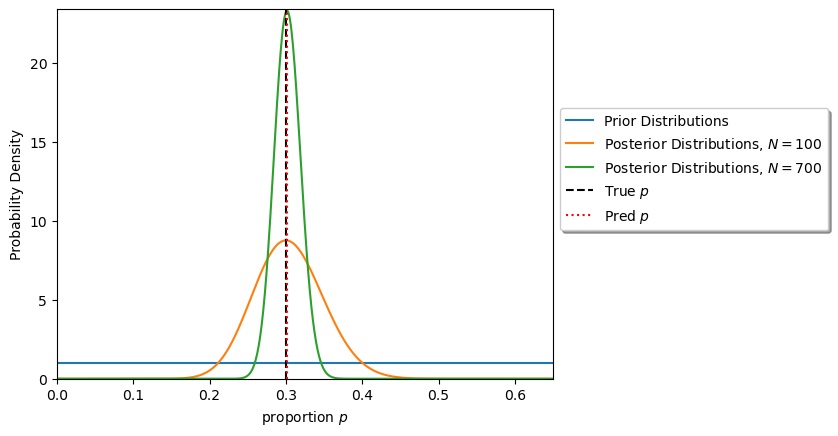

In [45]:
# define the prior and data distributions
def prior(p):
    return 1

def data_distribution(x,p):
    if x == 1:
        return p
    elif x == 0:
        return 1 - p
        
# sample prior for plotting
x = np.linspace(0,1,1000)
y1 = [prior(xi) for xi in x] 

# Create an experiment and get results, using 100 coins.
true_p = 0.3
exp = experiment(true_p,100)
exp.flip_coins()
data = exp.get_results()

# Create "Bayesian learner" object.
learner = bays_learner(prior,data_distribution)

# Create posterior distribution given data from the first experiment.
post1 = lambda x: learner.posterior_dist(data,x)
y2 = post1(x)

# Create a second experiment and get results, using 700 coins.
exp = experiment(true_p,700)
exp.flip_coins()
data = exp.get_results()

# Create posterior distribution given data from the second experiment.
post1 = lambda x: learner.posterior_dist(data,x)
y3 = post1(x)

# Compute MAP point estimate for the proportion.
pred_p = learner.get_map(data)

# Plotting results
fig = plt.figure()
plt.plot(x,y1,label='Prior Distributions')
plt.plot(x,y2,label='Posterior Distributions, $N=100$')
plt.plot(x,y3,label='Posterior Distributions, $N=700$')

plt.axvline(x=true_p,color='k',linestyle='--', label='True $p$')
plt.axvline(x=pred_p,color='r',linestyle=':', label='Pred $p$')
plt.xlabel('proportion $p$')
plt.ylabel('Probability Density')
plt.xlim([0,0.65])
plt.ylim([0,np.max(y3)+0.1])
plt.legend(fancybox=True, shadow=True,bbox_to_anchor=(1,0.75));

# Naive Baye's Classifier

The following is an implementation of the Naive Bayes Classifier, particularly the Gaussian Naive Bayes Classifier, for a toy problem. Specifically, determining if a point is inside or outside of a collection of specified circles in $\mathbb{R}^2$. In this case, inclusion within each circle is represented by its own class, and outside of all circles is again its own class.

The classifier performs quite while despite its simplicity, although it slightly over-estimates the size of the circle that defines membership. In addition to its simplicity, the Gaussian Naive Bayes Classifier has a prominent advantage over multi-class (multinomial) logistics regression. Specifically, it is able to perform classifications when the classes are not linearly separable. Where traditional logistics regression cannot do this, requiring either a higher dimensional embedding, resulting in linearly separable data, or the use of an assumed non-linear predictor function (see [generalized additive models](https://en.wikipedia.org/wiki/Generalized_additive_model)). Gaussian Naive Bayes classifier also seems to be much easier to implement than a support vector machine classification model, which can deal with non-linearly separable data using the kernel trick. This makes the Gaussian Naive Bayes Classifier a nice choice for applications in which it can still perform well. However, it should be noted that while the Gaussian Naive Bayes Classifier performs while for a circular boundary, the more complex the boundary house the more likely it will not perform well. For example, if the classes were determined by inclusion inside a star shape in $\mathbb{R}^2$. It is likely that the Gaussian Naive Bayes Classifier will classify test data into a more circular shape, in this case. I leave it to the reader to consider why this is the case. 

An additional extension, which I hope to include in the future, is to use a hierarchical Bayes model of the conditional probabilities, which is, hopefully, more accurate than simply estimating the mean and standard deviation of the training data. In this case, the mean and standard deviation of data in each class will themselves be random variables drawn from distributions (see [Bayesian hierarchical modeling](https://en.wikipedia.org/wiki/Bayesian_hierarchical_modeling)). 

In [2]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize_scalar
import random
from scipy.stats import norm
import seaborn as sns
from matplotlib import pyplot as plt

# Creates an experiment object that is given a number of points to create, the circle centers, corresponding radii, and bounds in R^2.
# It includes methods to generate the desired number of points, classify them, and return the resulting data.
class experiment:

    def __init__(self,num_points,circle_centers,circle_radii,bounds):
        self.R = circle_radii
        self.bounds = bounds
        self.circle_centers = circle_centers
        self.N = num_points
        self.generate_points()
        self.classify_points()

    def generate_points(self):
        self.points = (self.bounds[1] - self.bounds[0])*np.random.rand(self.N,2) + self.bounds[0]

    def classify_points(self):
        self.labels = np.zeros(self.N)
        for j, X in enumerate(self.points):
            temp_array = np.zeros(len(self.R)).astype(bool)
            for i, center in enumerate(self.circle_centers):
                XC , YC = center
                temp_array[i] = (X[0]-XC)**2 + (X[1]-YC)**2 < self.R[i]**2   
            if np.any(temp_array):
                self.labels[j] = np.where(temp_array.astype(bool) == True,)[0][0] + 1
        
    def return_training_data(self):
        return self.points , self.labels.astype(int)

# Creates a "Bayesian learner" object given a prior distribution for the classes, the assumed distribution of the data (Gaussian), and the class labels.
# It includes methods to compute the likelihood, train on a given set of data, produce the posterior distribution, and classify a given point of data.
class bayes_learner:

    def __init__(self, prior_dist, data_dist, classes):
        self.num_classes = len(classes)
        self.classes = np.array(classes)
        self.prior_dist = prior_dist
        self.data_dist = data_dist

    def likelihood(self,datum,cls):
        prod = 1
        for i, feature in enumerate(datum):
            muk = self.feature_means[np.where(cls == self.classes)[0],i]
            stdk = self.feature_stds[np.where(cls == self.classes)[0],i]
            param = [muk, stdk]
            prod = prod*self.data_dist(feature, param)
        return prod
    
    def train(self,feature_data,label_data):
        self.feature_means = np.zeros((self.num_classes,len(feature_data[0,:])))
        self.feature_stds = np.zeros((self.num_classes,len(feature_data[0,:])))
        for i , label in enumerate(self.classes):
            label_features = feature_data[label_data == label,:]
            self.feature_means[i,:] = np.mean(label_features, axis=0)
            self.feature_stds[i,:] = np.std(label_features, axis=0)
    
    def postiror_dist(self,datum,cls):
        
        temp = lambda x: self.likelihood(datum,x)*self.prior_dist(x)
        C = sum([temp(value) for value in self.classes])
        
        post_dist = self.likelihood(datum,cls)*self.prior_dist(cls) 
        return post_dist[0]

    def classifier(self,datum):
        probs = [self.postiror_dist(datum,param) for param in self.classes]
        return self.classes[(probs == max(probs)).flatten()]

    def classify_all(self,data):
        pred_labels = np.zeros(data.shape[0])
        for i , datum in enumerate(data):
            pred_labels[i] = learner.classifier(datum)[0]

        return pred_labels

The above-defined classes allow for the creation of simulated "experimental" data, with labels, the training of the Bayesian classifier, and the testing of its performance. In the following plots, we see that the classifier mostly successfully classifies the given test data correctly with the exception of a slightly larger circle in which it classifies points. However, it is successful in capturing the non-linear boundaries of the classifications, which is very nice for such a simple process.

Text(0.5, 1.0, 'Misclassified Points')

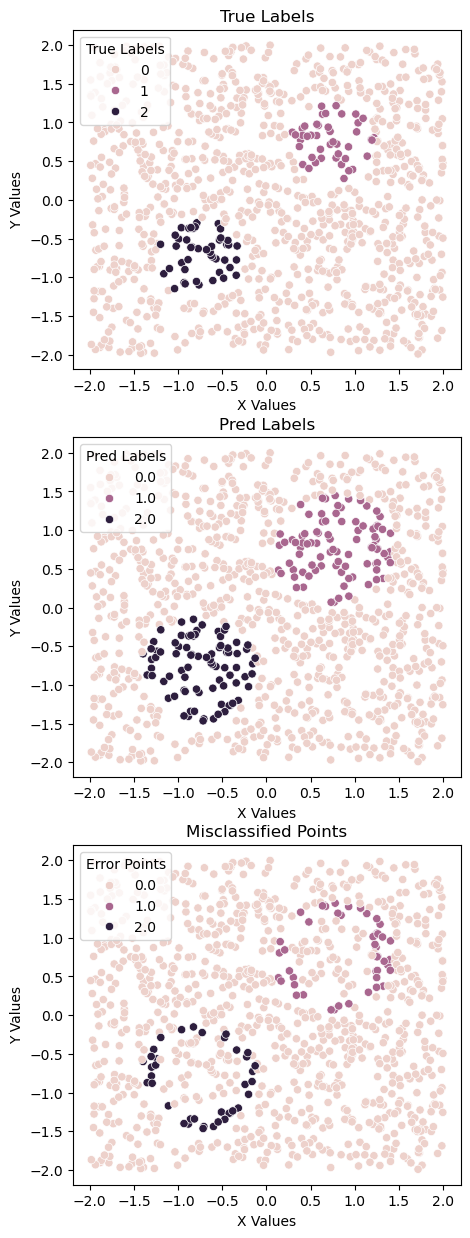

In [10]:
# define the prior and data distributions
def prior_dist(cls):
    classes = [0,1,2]
    if np.any(np.array(classes) == cls):
        return 1/len(classes)

def data_dist(x,params):
    mu,std = params
    return norm.pdf(x,loc = mu, scale = std)

# defines parameters such that bounds in R^2, circle centers, radii, class labels, and number of training points.
bounds  = [-2,2]
circle_centers = [[0.75,0.75],[-0.75,-0.75]]
circle_radii = [0.5,0.5]
class_labels = [0,1,2]
num_samples = 1000

# creates the training data.
exp_train = experiment(num_samples, circle_centers,circle_radii,bounds)
training_data_features,training_data_labels = exp_train.return_training_data()

# creates the testing data
exp_test = experiment(num_samples, circle_centers,circle_radii,bounds)
testing_data_features , testing_data_labels = exp_test.return_training_data()

# creates the learner objects, trains the learner on the data, and classifies the testing data.
learner = bayes_learner( prior_dist, data_dist, class_labels)
learner.train(training_data_features,training_data_labels)
pred_labels = learner.classify_all(testing_data_features)

# stores results of testing data in a dataframe for plotting.
test_data_df = pd.DataFrame({'X Values': testing_data_features[:,0], 'Y Values': testing_data_features[:,1], 'Pred Labels':pred_labels, 'True Labels':testing_data_labels, 'Error Points': np.abs(pred_labels - testing_data_labels)})

# plots results showing the correct classification of testing data, the predicted (pred) classifications from the learner, and the mislabeled points.
fig, axs = plt.subplots(3,1,figsize = (5,15))
sns.scatterplot(data = test_data_df, x='X Values',y='Y Values',hue='True Labels',ax=axs[0]); axs[0].set_title('True Labels')
sns.scatterplot(data = test_data_df, x='X Values',y='Y Values',hue='Pred Labels',ax=axs[1]); axs[1].set_title('Pred Labels')
sns.scatterplot(data = test_data_df, x='X Values',y='Y Values',hue='Error Points',ax=axs[2]); axs[2].set_title('Misclassified Points')

### Author:

Dr. Corbit R. Sampson, Ph.D

University of Colorado, Boulder

### Refernces

* Hogg, McKean, Craig (2005) *Introduction to Mathematical Statistics*
* Wikipedia: Naive Bayes Classifier at [https://en.wikipedia.org/wiki/Naive_Bayes_classifier](https://en.wikipedia.org/wiki/Naive_Bayes_classifier)
* Geeks for Geeks tutorial [https://www.geeksforgeeks.org/machine-learning/naive-bayes-classifiers/](https://www.geeksforgeeks.org/machine-learning/naive-bayes-classifiers/) (updated 21 May, 2025)
